In [1]:
# Importing the required libraries
import sys
import argparse
import numpy as np
import math
from utils import move
import random
import matplotlib.pyplot as plt
from QuadMDP.QuadTree import Point, Rect
from QuadMDP.QuadMDP import QuadMDP
from utils.Obstacle import Obstacle, Agent
from utils.Global import Global
from utils.agent_graph import *
from matplotlib.animation import FuncAnimation
from utils.RandomMap import RandomMap
import time
import csv

Map Width: 128
Map height: 128


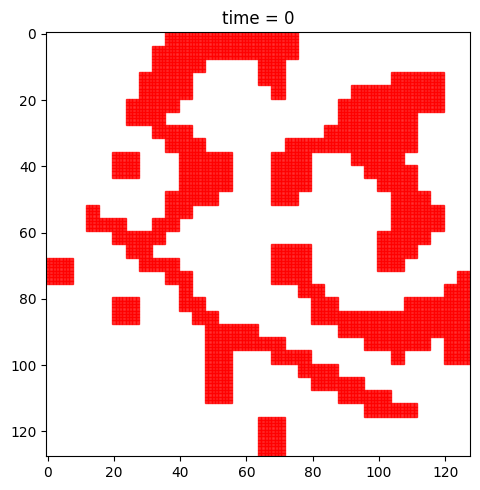

In [2]:
# Initializing the world from the picture
filename = '1.png'
image = plt.imread('map/' + filename)
mapWidth, mapHeight = image.shape
print("Map Width:", mapWidth)
print("Map height:", mapHeight)
mapDepth = (int)(math.log(mapWidth,2))
searchDepth = 2 # Search depth within QuadMDP

# Global class for the whole environment
g = Global((mapWidth,mapHeight))

startPos = (8,8)
goalPos = (119,8)

# QuadMDP class for generating the quad decomposed states
quad = QuadMDP(Rect(mapWidth/2-0.5,mapHeight/2-0.5,mapWidth,mapHeight),mapDepth)

# Initialize time collection
times = [0] #first entry is time steps, second+third are realtime global path search


# Load all obstacles
for x in range(mapWidth):
    for y in range(mapHeight):
        if image[y,x] == 0:
            g.createObstacle(move.NONE,(x,y))
            quad.insert(Point(x,y,True))


fig, ax = g.plot()
# Define the pixel coordinates
x = 50
y = 50

# Plot the pixel as green
ax.plot(x, y, marker='s', markersize=20, color='green')

In [3]:

# Generate quad decomposed states
S = quad.findEmptySpace(searchDepth)
graph = quad.generateGraph(S, searchDepth)

# Generate the start position and the goal

startQuadMDP = quad.findContainedQuadMDP(startPos)
goalQuadMDP = quad.findContainedQuadMDP(goalPos)

DFS = False  # set to True to use DFS instead of BFS
Simple = True

# Get the optimal path in the Quadtree representation

if DFS:  # DFS
    path_dfs = quad.getPathDFSV2(S,searchDepth,startQuadMDP,goalQuadMDP, path = [], visited = set())
    path = [element.getTuple() for element in path_dfs]
else:  # BFS
    times.append(time.perf_counter())
    path = quad.getOptimalPath(S,searchDepth,startQuadMDP.getTuple(),goalQuadMDP.getTuple())
    times.append(time.perf_counter())
path.append(goalPos)


# Projecting the path to the Global representation
for i, p in enumerate(path):
    decision = np.random.randint(0, 3)
    if decision == 0:
        path[i] = (math.floor(p[0]), math.floor(p[1]))
    if decision == 1:
        path[i] = (math.ceil(p[0]), math.floor(p[1]))
    if decision == 2:
        path[i] = (math.floor(p[0]), math.ceil(p[1]))
    if decision == 3:
        path[i] = (math.ceil(p[0]), math.ceil(p[1]))

print("Path we want to take: ", path)

Path we want to take:  [(7, 7), (7, 24), (7, 40), (4, 51), (4, 59), (5, 65), (11, 68), (12, 75), (8, 87), (15, 112), (39, 120), (55, 119), (65, 114), (69, 113), (76, 115), (87, 119), (100, 123), (107, 124), (120, 119), (115, 108), (107, 107), (105, 101), (99, 100), (91, 100), (89, 94), (83, 92), (75, 91), (75, 83), (67, 84), (66, 77), (56, 71), (60, 59), (59, 51), (59, 43), (59, 36), (55, 23), (67, 28), (69, 21), (76, 19), (76, 11), (87, 8), (100, 3), (108, 3), (116, 3), (118, 9), (119, 8)]


In [4]:
# Create the moving obstacles
moving_obstacles = []  # store the moving obstacles
moving_obstacles_positions = dict()  # store the positions of the moving obstacles over time
num_obstacles = 200
a = np.random.randint(0, [[mapWidth],[mapHeight]], size = (2,num_obstacles)).T

for element in a:  # creating random moving obstacles
    obs1 = g.createObstacle(move.RANDOM,tuple(element))  # moving obstacles with random dynamics
    moving_obstacles.append(obs1)
    moving_obstacles_positions[obs1] = [tuple(element)]

Initial position


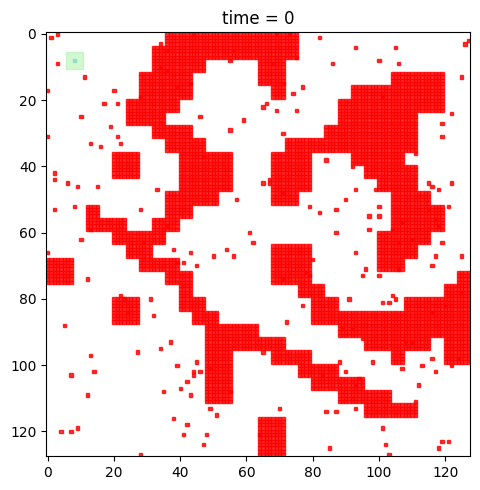

Obstacle trying to leave the world or bumping into agent, staying still
Obstacle trying to leave the world or bumping into agent, staying still
careful, obstacles just collided
(8, 7)
(7, 7)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Obstacle trying to leave the world or bumping into agent, staying still
careful, obstacles just collided
(7, 7)
(7, 7)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
careful, obstacles just collided
(7, 8)
(7, 24)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Obstacle trying to leave the world or bumping into agent, staying still
careful, obstacles just collided
(7, 9)
(7, 24)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Obstacle trying to leave the world or bumping into agent, staying still
careful, obstacles just collided
(7, 10)
(7, 24)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 

In [5]:
# Create the agent
agent = g.createAgent(startPos)
agent.range = 2

# Print the initial state of the world
print("Initial position")
g.plot()


# Retrieve the dimensions of the picture and the first observation
Xlim, Ylim = mapWidth, mapHeight
obs = g.observe()

# Build observation environment
Graph = agent_graph(agent, obs, Xlim, Ylim)

# Initialization
idx_goal = 0  # index of the intermediary goal we are considering
complete_path = []
current_state = tuple(agent.location)
not_moving_count = 0
while idx_goal < len(path):

    # Grab the current goal and project it to the observation environment
    goal = tuple(path[idx_goal])
    projected_goal = Graph.project_to_surroundings(goal)

    # Get the optimal path on the low level
    if DFS:  # DFS
        inter_path =  Graph.get_path_DFS(current_state, projected_goal, [], set())
    else:  # BFS
        inter_path = Graph.get_optimal_path(current_state, projected_goal)
    

    # Get to the next state on the path
    next_state = inter_path[1]
    action = np.array(next_state) - np.array(current_state)

    # Check that we are not stuck in a corner
    if np.array_equal(action, move.NONE):
        not_moving_count += 1
    else:
        not_moving_count = 0

    # If stuck for some reason, go back to the previous goal
    if not_moving_count > 10 and action == move.NONE and idx_goal >= 1:
        idx_goal -= 1
        not_moving_count = 0

    # Updating the state of the agents and the moving obstacles
    agent.action = action
    g.next()
    times[0] += 1


    # Position of the agent after moving
    current_state = tuple(agent.location)
    complete_path += [current_state]
    print(current_state)
    print(goal)

    # Check how the environment look now
    #g.plot()  # deactivate for gain of time

    # Get new observation
    obs = g.observe()
    print(obs)

    # Tracking the positions of the obstacles
    for obstacle in moving_obstacles:
        moving_obstacles_positions[obstacle].append(tuple(obstacle.location))

    # Load the new graph corresponding to the new positions of the agent and its new observation
    Graph = agent_graph(agent, obs, Xlim, Ylim)
    if current_state == goal: # If we have reached the goal, we go to the next one
        idx_goal += 1

# Upload the entire trajectory so as to plot it
g.complete_path = complete_path

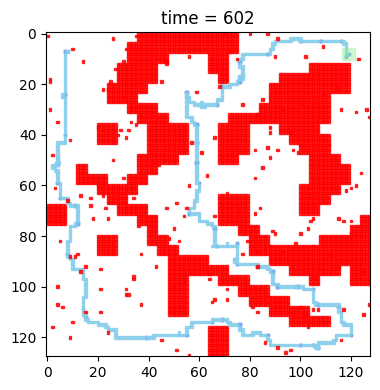

In [6]:
# Initialize the picture for plotting
figsize = 4
fig, ax = plt.subplots(1, 1, figsize=(g.x_dim/g.y_dim*figsize, figsize))
plt.title("time = " + str(g.time))
ax.set_xlim([-0.5,g.x_dim-0.5])
ax.set_ylim([-0.5,g.y_dim-0.5])
ax.set_aspect('equal')
ax.invert_yaxis()
plt.tight_layout()


# Plot the fixed obstacles outside of plot_agent so that they remain in the figure the entire simulation
for o in g.obstacles:
    if moving_obstacles_positions.get(o) is None:
        x,y = o.location
        rx = [x-0.5,x+0.5,x+0.5,x-0.5]
        ry = [y-0.5,y-0.5,y+0.5,y+0.5]
        plt.fill(rx,ry,color='red',zorder=-2, alpha=0.8)

# plotting the global path to follow in blue outside of plot_agent so that they remain in the figure the entire simulation
for state in path:
    x, y = state
    rx = [x-0.5,x+0.5,x+0.5,x-0.5]
    ry = [y-0.5,y-0.5,y+0.5,y+0.5]
    plt.fill(rx,ry,color='blue',zorder=-2, alpha=1)

# Keeping track of specific artist elements being plotted so as to replace them at each iteration of plot_agent
moving_obstacles_artists_list = []  # made to contain the plotted positions of the moving obstacles
observation_artist_list = []  # made to contain the plotted observations 

def plot_agent(i):  # i = frame number
    # iterative plotting function
    
    plt.title("time = " + str(i))
    
    for element in moving_obstacles_artists_list:  # remove from the figure the previous positions of the moving obstacles
        if len(element) > 0:
            line = element.pop(0)  # remove from the list
            line.remove()  # remove from the figure
    
    
    # Plotting the agents position at time i
    a = g.agents[0]
    x,y = g.complete_path[i]
    rx = [x-0.5,x+0.5,x+0.5,x-0.5]
    ry = [y-0.5,y-0.5,y+0.5,y+0.5]
    plt.fill(rx,ry,color='skyblue',zorder=-2, alpha=0.8)

    # Plotting the observation at time i
    ax_min = max(0, x-a.range)
    ax_max = min(g.x_dim-1, x+a.range)
    ay_min = max(0, y-a.range)
    ay_max = min(g.y_dim-1, y+a.range)
    rx = [ax_min-0.5, ax_max+0.5, ax_max+0.5, ax_min-0.5]
    ry = [ay_min-0.5, ay_min-0.5, ay_max+0.5, ay_max+0.5]
    
    for element in observation_artist_list:
        if len(element)> 0:  # remove the previous observation from the plot
            line = element.pop(0)
            line.remove()

    observation_artist_list.append(plt.fill(rx, ry, color='lightgreen', zorder=-2, alpha=0.4))  # add the new observation to the list of plotted elements (to remove it next iteration)

    # plotting moving obstacles
    for o in moving_obstacles:
        x,y = moving_obstacles_positions[o][i]
        rx = [x-0.5,x+0.5,x+0.5,x-0.5]
        ry = [y-0.5,y-0.5,y+0.5,y+0.5]
        ln = plt.fill(rx,ry,color='red',zorder=-2, alpha=0.8)  # plotting
        moving_obstacles_artists_list.append(ln)  # adding the artist so we can remove it at the next iteration




# building the animation object
ani = FuncAnimation(fig, plot_agent, frames=len(complete_path), interval=100, repeat=False)

# Either show or save as a gif (one cancels the other so you need to execute only one)
#plot_agent(300)
#plt.show()
ani.save('animation%4f.gif' % (time.time()), writer='imagemagick', fps=10)